In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist


In [172]:
# Checking available sheet names
xls = pd.ExcelFile('EastWestAirlines.xlsx')
print(xls.sheet_names)


['Description', 'data']


In [173]:
# Loading the actual data sheet
data = pd.read_excel(xls, sheet_name='data')

In [174]:
data.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID#                3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award?             3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


In [176]:
data.describe()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3999.000000,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,2014.819455,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1160.764358,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,1.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1010.500000,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,2016.000000,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,3020.500000,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,4021.000000,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


In [177]:
data.isnull().sum()

,0
ID#,0
Balance,0
Qual_miles,0
cc1_miles,0
cc2_miles,0
cc3_miles,0
Bonus_miles,0
Bonus_trans,0
Flight_miles_12mo,0
Flight_trans_12,0


In [178]:
data.shape

(3999, 12)

In [179]:
data.columns

Index(['ID#', 'Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
       'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12',
       'Days_since_enroll', 'Award?'],
      dtype='object')

In [180]:
data.drop("ID#",axis=1,inplace=True)

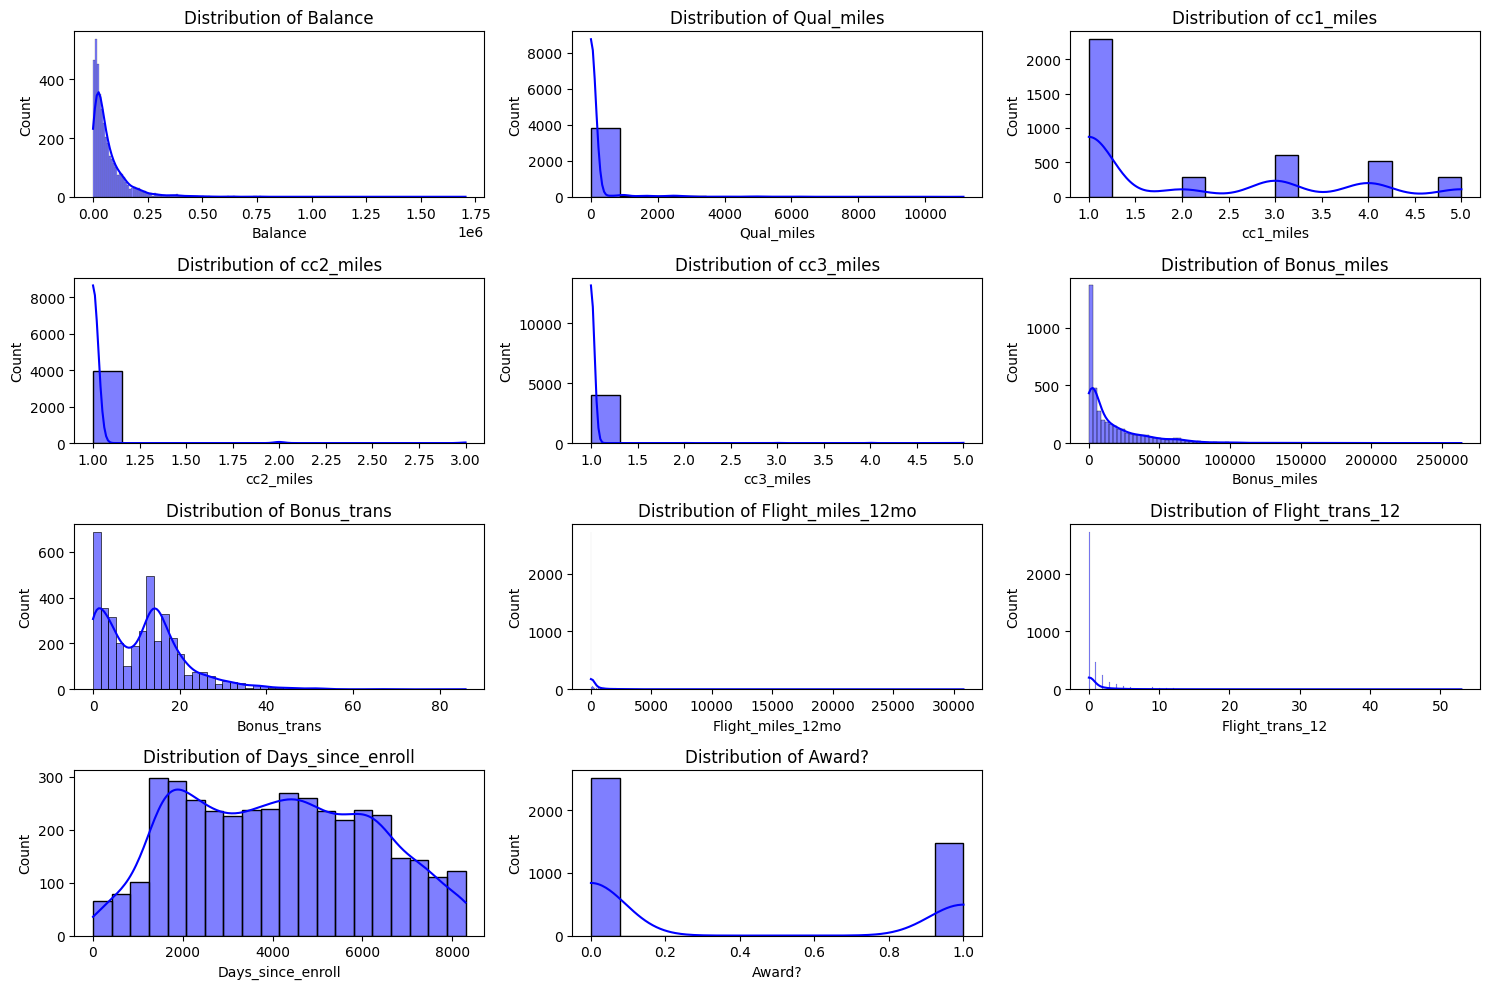

In [181]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(data.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data[col], kde=True, color='blue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

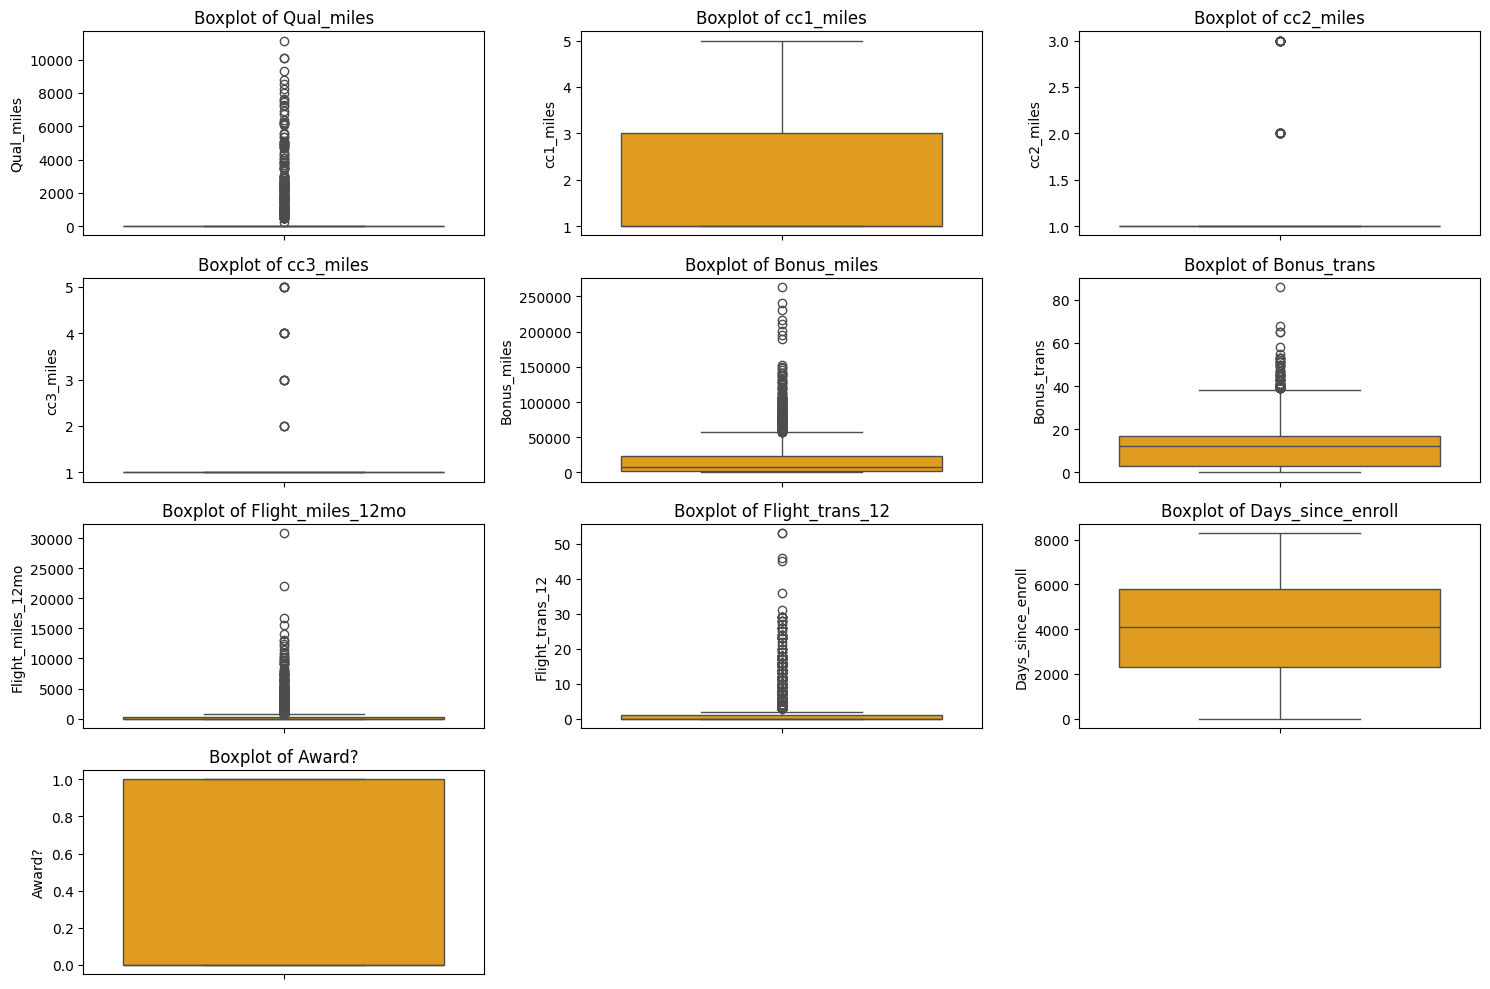

In [182]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(data.columns[1:], 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=data[col], color='orange')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [183]:
data['cc2_miles'].nunique()


3

In [184]:
data["cc3_miles"].nunique()

5

In [185]:
# Dropping cc2_miles and cc3_miles because they are rarely used and mostly zeros
data.drop(['cc2_miles', 'cc3_miles'], axis=1, inplace=True)

In [186]:
# Removing outliers using IQR method
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Keeping only rows where all values are within the IQR bounds
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]


In [187]:
#scaling data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)


In [188]:
scaled_df

,Balance,Qual_miles,cc1_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,-0.439145,0.0,-0.713728,-0.787314,-1.091601,-0.377811,-0.408954,1.504149,-0.621738
1,-0.648329,0.0,-0.713728,-0.784309,-0.962212,-0.377811,-0.408954,1.488487,-0.621738
2,-0.128602,0.0,-0.713728,-0.497870,-0.703433,-0.377811,-0.408954,1.520789,-0.621738
3,-0.753356,0.0,-0.713728,-0.763419,-1.091601,-0.377811,-0.408954,1.480656,-0.621738
4,-0.714712,0.0,-0.713728,-0.800067,-1.220990,-0.377811,-0.408954,1.475761,-0.621738
...,...,...,...,...,...,...,...,...,...
2904,-0.666382,0.0,-0.713728,-0.175224,-0.703433,0.955424,1.656407,-1.235227,1.608394
2905,0.412775,0.0,-0.713728,-0.728164,-0.574044,-0.377811,-0.408954,-1.239143,1.608394
2906,0.629316,0.0,1.022255,1.065082,-0.185877,-0.377811,-0.408954,-1.235717,1.608394
2907,0.189793,0.0,-0.713728,-0.763419,-1.091601,2.955277,1.656407,-1.236206,-0.621738


visulizations to understand hidden patterns


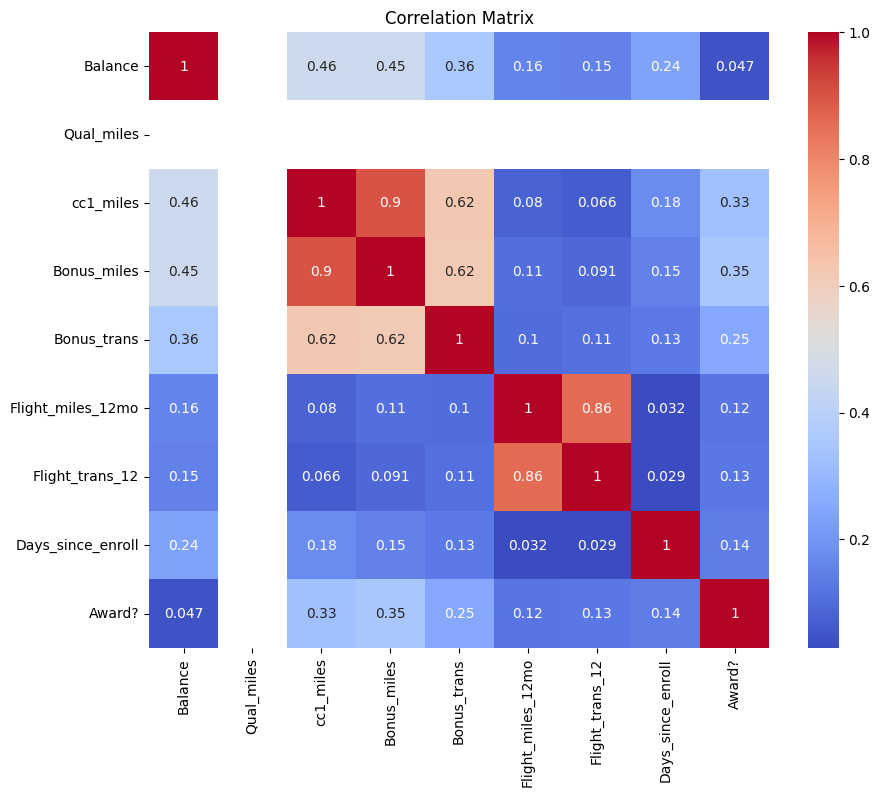

In [189]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

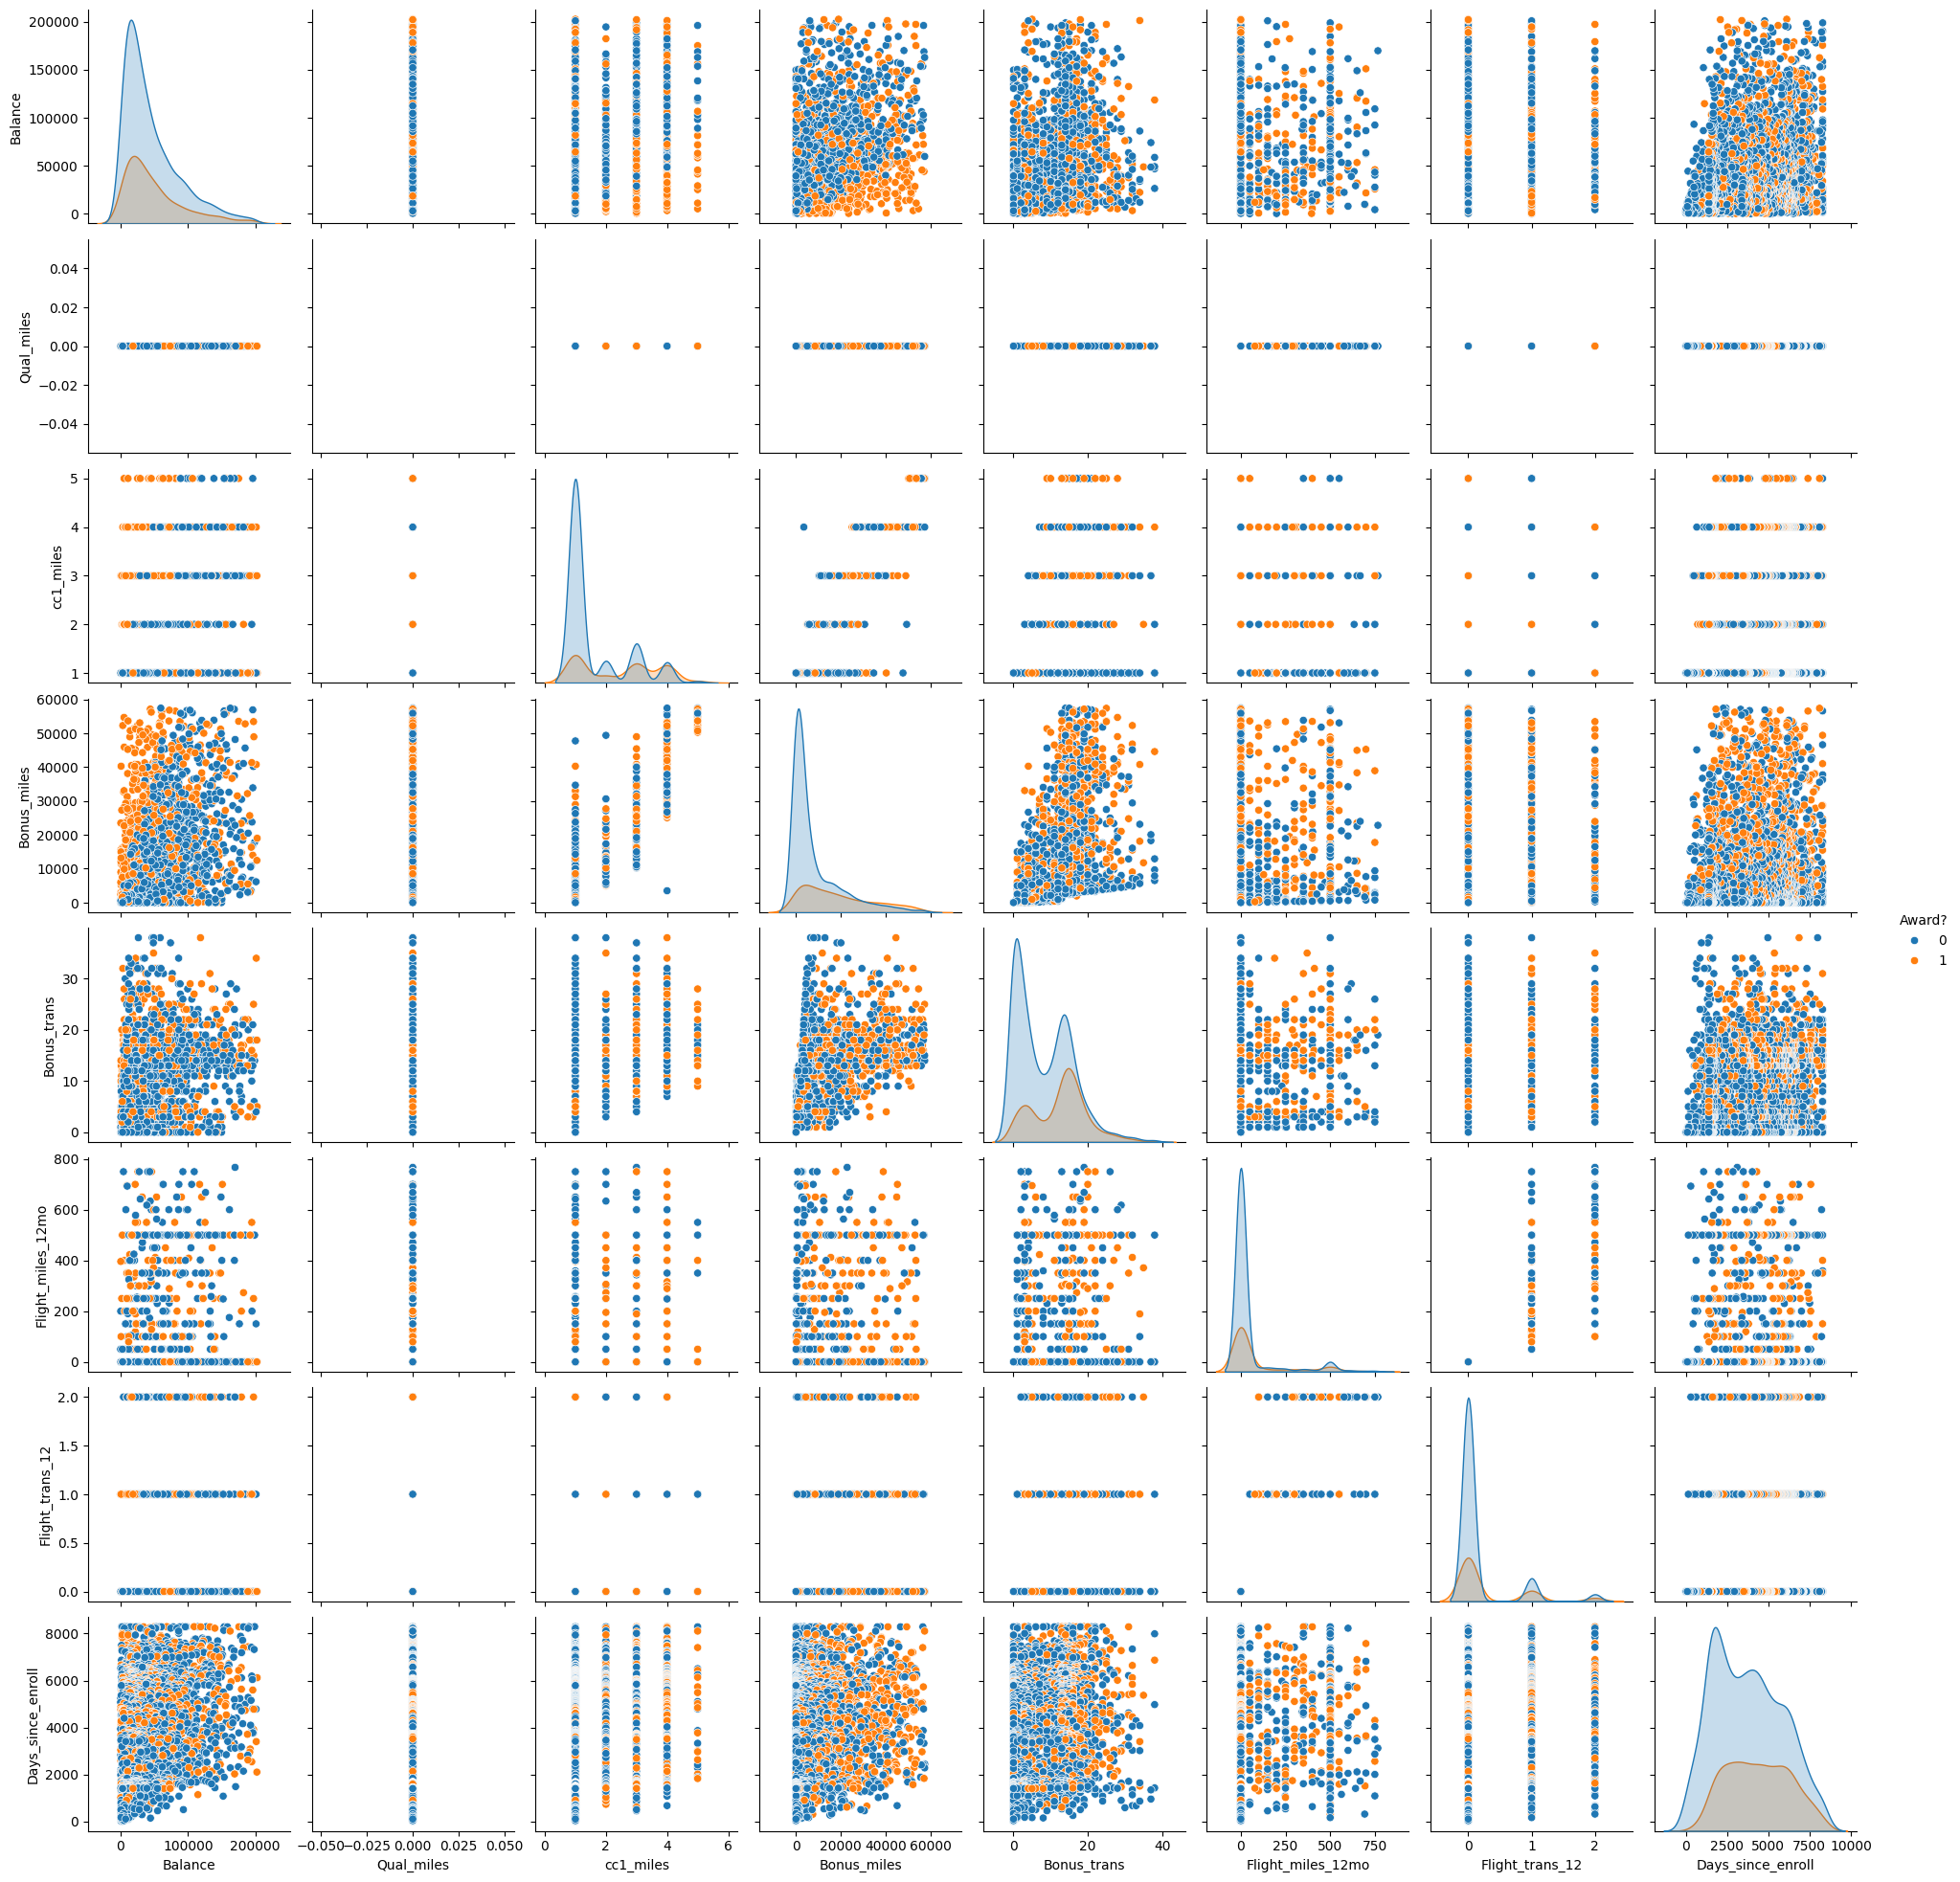

In [190]:
sns.pairplot(data, hue='Award?', diag_kind='kde')
plt.show()

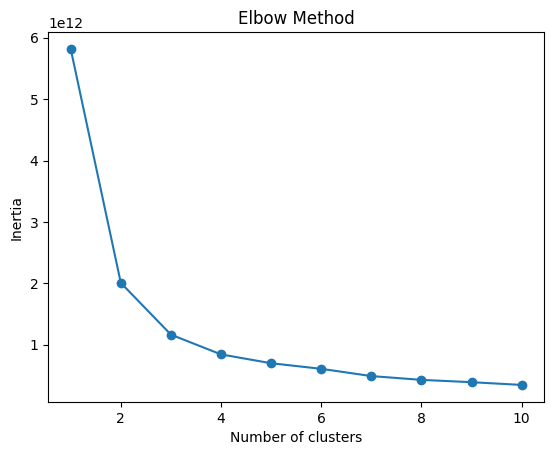

In [191]:
# Plotting inertia to find optimal number of clusters (Elbow point)
inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(data)
    inertia.append(km.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [192]:
# Fitting K-Means with k = 3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(data)

# Adding cluster labels to the DataFrame
data['KMeans_Cluster'] = kmeans_labels


In [193]:
# Cluster-wise feature averages to understand each group
data.groupby('KMeans_Cluster').mean()


,Balance,Qual_miles,cc1_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
KMeans_Cluster,,,,,,,,,
0,138666.266862,0.0,2.759531,22028.457478,13.782991,97.334311,0.310850,4907.375367,0.316716
1,19290.086256,0.0,1.359402,5552.703278,7.079931,37.686601,0.140311,3575.184589,0.254744
2,66807.032569,0.0,2.407720,17594.410133,12.592280,79.785283,0.272618,4260.949337,0.313631


In [194]:
from sklearn.decomposition import PCA


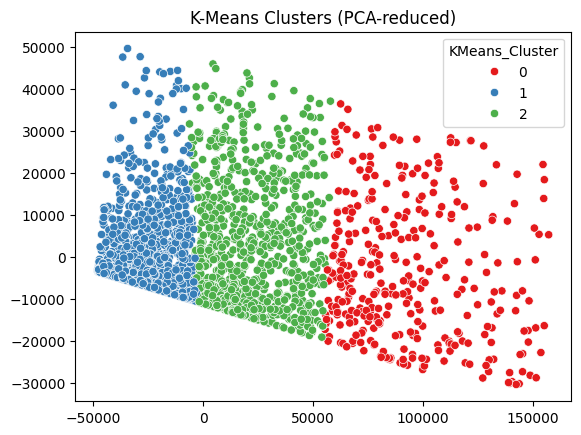

In [195]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data.drop('KMeans_Cluster', axis=1))

# Plot clusters
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=data['KMeans_Cluster'], palette='Set1')
plt.title('K-Means Clusters (PCA-reduced)')
plt.show()

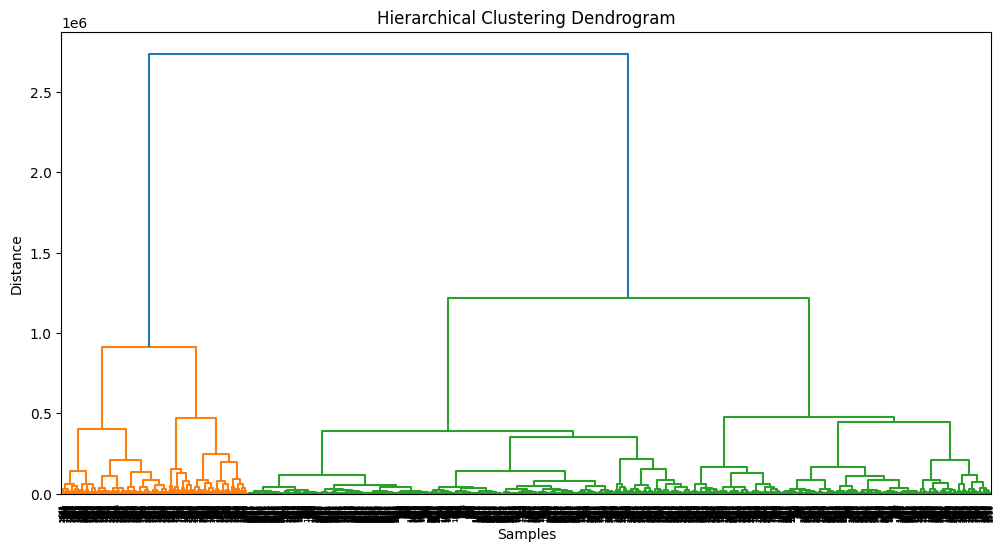

In [196]:
# Creating linkage matrix using 'ward' method
linkage_matrix = linkage(data.drop('KMeans_Cluster', axis=1), method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


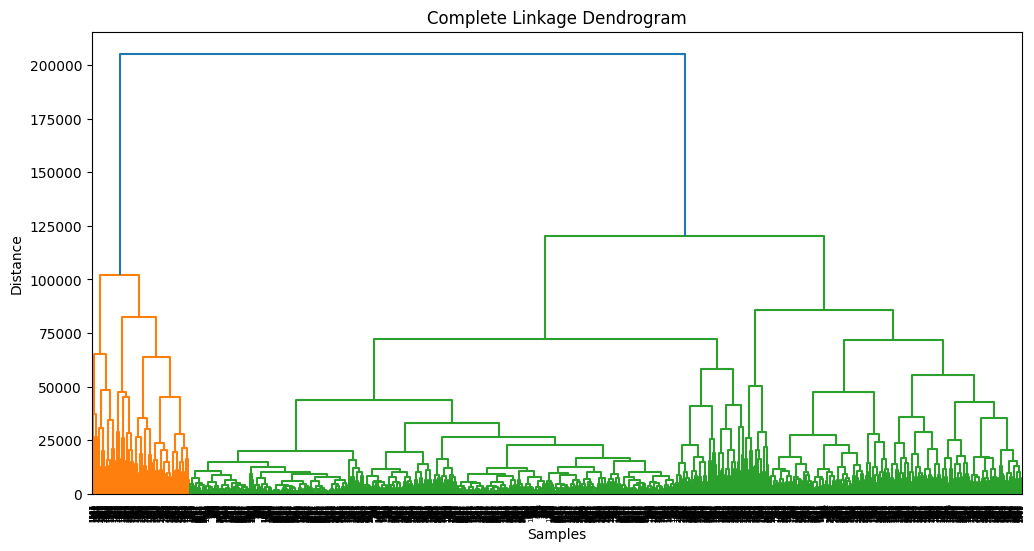

In [197]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Creating linkage matrix using 'complete' method
linkage_matrix_complete = linkage(data.drop('KMeans_Cluster', axis=1), method='complete')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix_complete)
plt.title('Complete Linkage Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


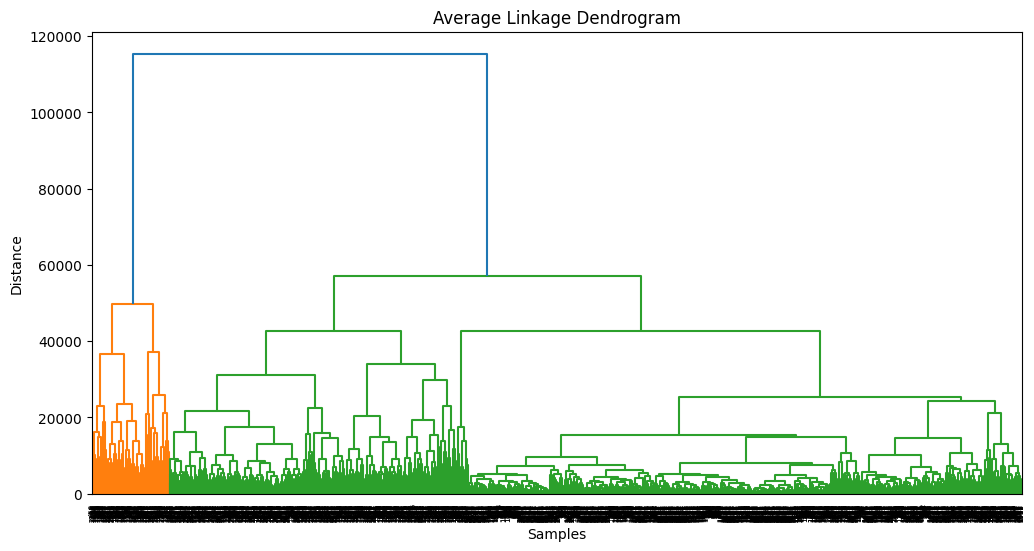

In [198]:
# Creating linkage matrix using 'average' method
linkage_matrix_average = linkage(data.drop('KMeans_Cluster', axis=1), method='average')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix_average)
plt.title('Average Linkage Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()



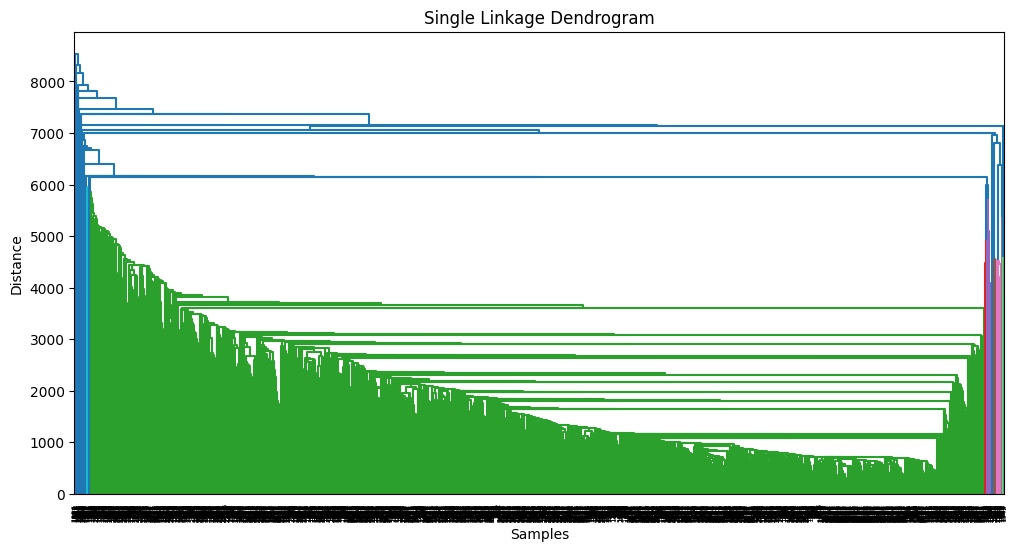

In [199]:
# Creating linkage matrix using 'single' method
linkage_matrix_single = linkage(data.drop('KMeans_Cluster', axis=1), method='single')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix_single)
plt.title('Single Linkage Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


In [200]:
# Assign cluster labels using Agglomerative Clustering with ward linkage
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
data['HC_Cluster'] = hc.fit_predict(data.drop('KMeans_Cluster', axis=1))

In [201]:
data.groupby('HC_Cluster').mean()

,Balance,Qual_miles,cc1_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,KMeans_Cluster
HC_Cluster,,,,,,,,,,
0,117803.924007,0.0,2.820380,22876.208981,14.096718,96.870466,0.314335,4701.438687,0.310881,0.822107
1,50502.667735,0.0,1.961538,12169.500000,10.588675,66.473291,0.240385,4070.723291,0.286325,1.631410
2,14874.259684,0.0,1.314204,5105.913917,6.727403,33.402439,0.121234,3508.362984,0.260402,1.000000


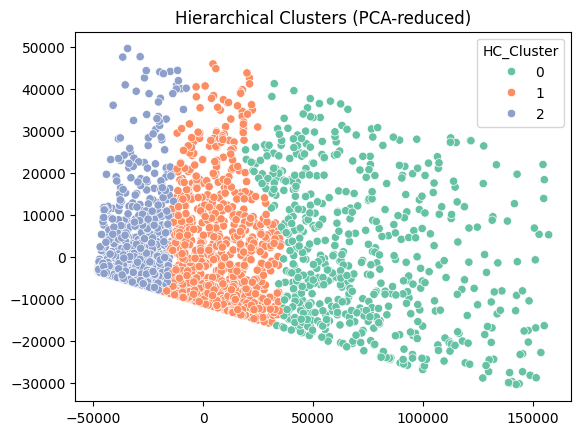

In [202]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data.drop(['KMeans_Cluster', 'HC_Cluster'], axis=1))

# Plot clusters
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=data['HC_Cluster'], palette='Set2')
plt.title('Hierarchical Clusters (PCA-reduced)')
plt.show()


In [203]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN with tighter distance threshold
dbscan = DBSCAN(eps=10, min_samples=5)
data['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_df)

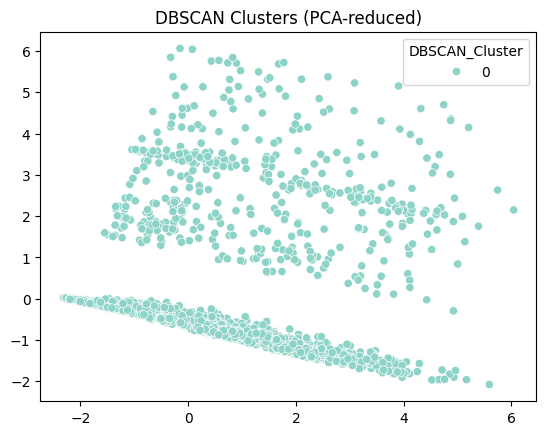

In [204]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_df)

# Plot DBSCAN clusters
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=data['DBSCAN_Cluster'], palette='Set3')
plt.title('DBSCAN Clusters (PCA-reduced)')
plt.show()


In [205]:
labels = data['DBSCAN_Cluster']
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = sum(labels == -1)

print(f"Clusters found: {n_clusters}")
print(f"Noise points: {n_noise}")


Clusters found: 1
Noise points: 0


In [206]:
# calculating score for K-Means to see how tight the clusters are
kmeans_score = silhouette_score(scaled_df, data['KMeans_Cluster'])
print("K-Means Silhouette Score:", round(kmeans_score, 3))

# checking how well Hierarchical clustering separated the data
hc_score = silhouette_score(scaled_df, data['HC_Cluster'])
print("Hierarchical Silhouette Score:", round(hc_score, 3))


K-Means Silhouette Score: 0.153
Hierarchical Silhouette Score: 0.089


In [207]:
# DBSCAN sometimes gives only one cluster, so I check before scoring
if len(set(data['DBSCAN_Cluster'])) > 1:
    dbscan_score = silhouette_score(scaled_df, data['DBSCAN_Cluster'])
    print("DBSCAN Silhouette Score:", round(dbscan_score, 3))
else:
    print("DBSCAN Silhouette Score: Not applicable")


DBSCAN Silhouette Score: Not applicable


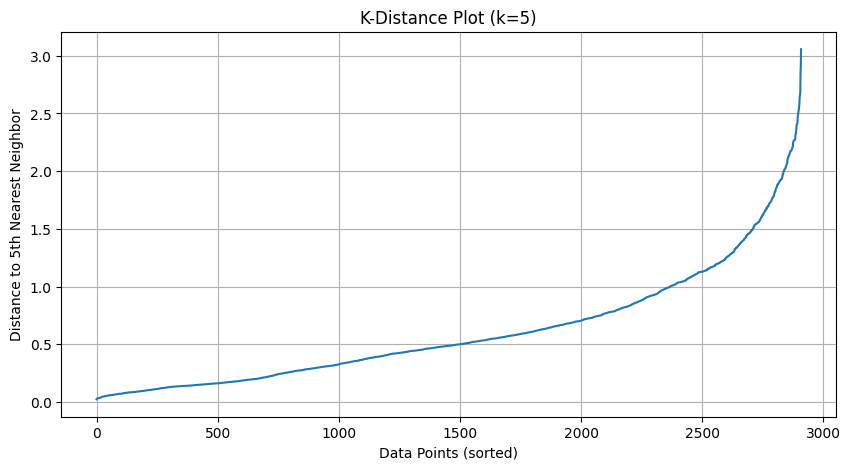

In [208]:
# First, I import the required modules for distance calculation and plotting
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# i choosed 5 neighbors to analyze the local density
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_df)  # scaled_df is my normalized dataset

#  calculate the distances to the 5 nearest neighbors
distances, indices = neighbors_fit.kneighbors(scaled_df)

# extracting the distance to the 5th nearest neighbor for each point
fifth_distances = distances[:, -1]  # using -1 instead of 4 for clarity

#  sorting these distances to visualize the elbow clearly
sorted_distances = np.sort(fifth_distances)

# Now plot the sorted distances to identify the optimal eps value
plt.figure(figsize=(10, 5))
plt.plot(sorted_distances)
plt.title("K-Distance Plot (k=5)")
plt.xlabel("Data Points (sorted)")
plt.ylabel("Distance to 5th Nearest Neighbor")
plt.grid(True)
plt.show()


In [209]:
#  running DBSCAN with tuned parameters based on my k-distance plot
dbscan = DBSCAN(eps=2.5, min_samples=6)
dbscan_labels = dbscan.fit_predict(scaled_df)  # scaled_df is my normalized data

#  add the cluster labels to my original dataframe
data['DBSCAN_Cluster'] = dbscan_labels

#  checking how many unique clusters DBSCAN has formed
print("Unique clusters formed:", set(dbscan_labels))

# calculating silhouette score only if more than one cluster is formed
if len(set(dbscan_labels)) > 1:
    score = silhouette_score(scaled_df, dbscan_labels)
    print("Silhouette Score:", round(score, 3))
else:
    print("Only one cluster formed — silhouette score not applicable.")


Unique clusters formed: {np.int64(0), np.int64(-1)}
Silhouette Score: 0.472


In [210]:
# After tuning DBSCAN with eps = 2.5 and min_samples = 6,
# the model formed one dense cluster and identified the rest as noise.
# The silhouette score was 0.472, indicating a well-separated and compact cluster.

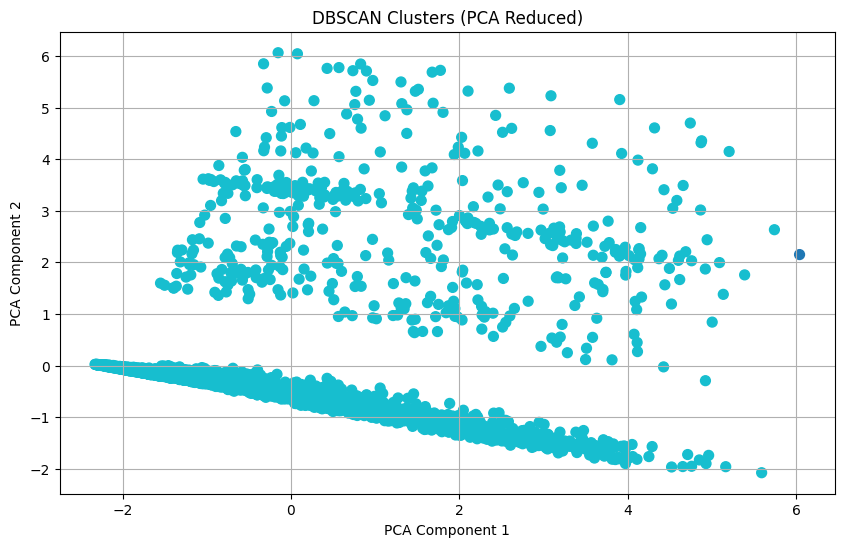

In [211]:
# using pca to reduce the scaled data in 2d format
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_df)

# plotting the DBSCAN clusters using the PCA-reduced data
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=data['DBSCAN_Cluster'], cmap='tab10', s=50)

# labeling the plot to make the cluster separation clear
plt.title("DBSCAN Clusters (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


In [212]:
# DBSCAN clustering was performed after estimating eps using a k-distance plot.
# Initial runs with eps = 3.0 and min_samples = 5 resulted in multiple clusters but poor separation (silhouette score = -0.035).
# After tuning to eps = 2.5 and min_samples = 6, DBSCAN formed one dense cluster with a silhouette score of 0.472, indicating strong separation.
# A PCA scatter plot was used to visualize the clustering result, confirming the presence of a compact cluster and distinct noise points.